In [4]:
# %matplotlib inline

import numpy as np
import os
from numba import njit

FILE_NAME = os.path.abspath('')
FILE_PATH = os.path.dirname(FILE_NAME)
FILE_BASE = os.path.basename(FILE_NAME)

import fastpli.simulation
import fastpli.analysis
import fastpli.tools
import fastpli.io
import sys
import h5py

import matplotlib.pyplot as plt

import tikzplotlib
from skimage.external import tifffile as tif

from vector_field_generation import *

np.random.seed(42)

print(fastpli.__version__)

fastpli: v0.9.4-2-g5b66a50
Branch: HEAD
Hash: 5b66a50
Build: Release


In [7]:
simpli = fastpli.simulation.Simpli()
simpli.omp_num_threads = 2
simpli.fiber_bundles = fastpli.io.fiber_bundles.load(os.path.join(FILE_PATH, '..', 'data', 'models', 'cube_2pop_psi_0.5_omega_0.0_.solved.h5'))
simpli.fiber_bundles_properties = [[(0.75, 0, 0, 'b'),
                                    (1.0, dn, 0, model)]] * len(
                                        simpli.fiber_bundles)

simpli.voxel_size = voxel_size  # in µm meter
simpli.set_voi([-5] * 3, [5] * 3)  # in µm meter

voxel_size_0 = simpli.voxel_size
scale = 2

scale: 2, model: p -> 153 MB
IntpVecField
diff
scale: 2, model: r -> 153 MB
IntpVecField
diff


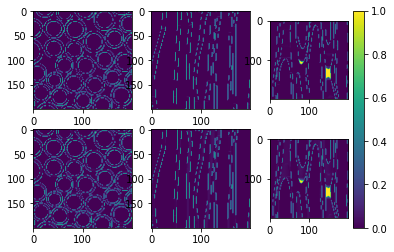

In [8]:
fig, axs = plt.subplots(2, 3)
for m, (dn, model) in enumerate([(-0.002, 'p'), (0.004, 'r')]):

    # low resolution   
    simpli.voxel_size = voxel_size_0  # in µm meter
    tissue, optical_axis, tissue_properties = simpli.generate_tissue()

    # high resolution
    simpli.voxel_size = voxel_size_0 / scale  # in µm meter
    print(f"scale: {scale}, model: {model} -> {simpli.memory_usage('MB'):.0f} MB")
    if simpli.memory_usage('MB') > 128**12:
        print("MEMORY!")
        sys.exit(1)
    tissue_high, optical_axis_high, tissue_properties = simpli.generate_tissue(
    )
    print("IntpVecField")
    vf_intp = IntpVecField(tissue, optical_axis, scale, True)
    print("diff")
    vf_diff = np.linalg.norm(VectorOrientationSubstractionField(
        optical_axis_high, vf_intp),
                             axis=-1)
    
    vmax = np.amax(vf_diff)
    axs[m, 0].imshow(vf_diff[vf_diff.shape[0] // 2, :, :],
                     vmin=0,
                     vmax=vmax)
    axs[m, 1].imshow(vf_diff[:, vf_diff.shape[1] // 2, :],
                     vmin=0,
                     vmax=vmax)
    pcm = axs[m, 2].imshow(vf_diff[:, :, vf_diff.shape[2] // 2],
                           vmin=0,
                           vmax=vmax)

    if m == 0:
        fig.colorbar(pcm, ax=axs[:, 2])

    # print(tissue_high.shape)
    # np.savez(f"test_vfdiff_{scale}.npz")
    # tif.imsave(f"vfdiff_{scale}.tiff", vf_diff, bigtiff=True)
    # tif.imsave(f"label_{scale}.tiff", tissue_high, bigtiff=True)

# plt.show()
# tikzplotlib.save(f"test_{scale}.tex")

plt.show()